In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 2.5 # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

250000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

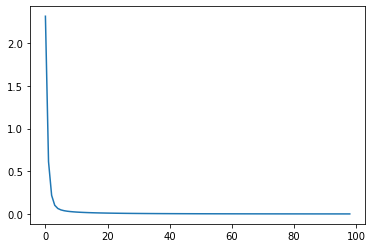

In [8]:
plt.plot(S)

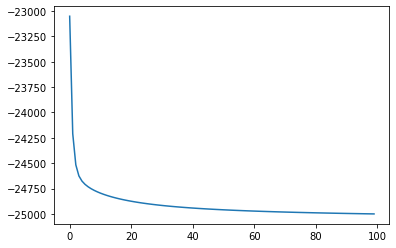

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0009602013872936368

In [11]:
eta

array([-23052.52694387, -24209.56701407, -24515.889868  , -24624.90961827,
       -24675.99384651, -24708.1959103 , -24732.13228233, -24751.46730908,
       -24767.82295588, -24782.05373632, -24794.66797992, -24805.99595932,
       -24816.26695781, -24825.64847564, -24834.26786132, -24842.22505029,
       -24849.60048122, -24856.46024305, -24862.85955359, -24868.84519048,
       -24874.45724027, -24879.73038965, -24884.69490021, -24889.37735931,
       -24893.80126859, -24897.98751248, -24901.95473648, -24905.71965621,
       -24909.29731273, -24912.70128549, -24915.94387159, -24919.03623765,
       -24921.98854954, -24924.81008385, -24927.5093241 , -24930.09404443,
       -24932.57138243, -24934.94790311, -24937.22965502, -24939.42221986,
       -24941.53075637, -24943.56003934, -24945.51449427, -24947.39822844,
       -24949.21505863, -24950.96853598, -24952.66196844, -24954.29844087,
       -24955.8808333 , -24957.41183733, -24958.89397108, -24960.3295927 ,
       -24961.72091268, -

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([1.94687306e+03, 7.89832987e+02, 4.83510133e+02, 3.74490382e+02,
       3.23406154e+02, 2.91204090e+02, 2.67267718e+02, 2.47932692e+02,
       2.31577045e+02, 2.17346264e+02, 2.04732021e+02, 1.93404041e+02,
       1.83133043e+02, 1.73751525e+02, 1.65132139e+02, 1.57174950e+02,
       1.49799519e+02, 1.42939758e+02, 1.36540447e+02, 1.30554810e+02,
       1.24942760e+02, 1.19669611e+02, 1.14705100e+02, 1.10022641e+02,
       1.05598732e+02, 1.01412488e+02, 9.74452641e+01, 9.36803444e+01,
       9.01026879e+01, 8.66987151e+01, 8.34561290e+01, 8.03637629e+01,
       7.74114511e+01, 7.45899168e+01, 7.18906765e+01, 6.93059562e+01,
       6.68286182e+01, 6.44520975e+01, 6.21703456e+01, 5.99777807e+01,
       5.78692442e+01, 5.58399613e+01, 5.38855063e+01, 5.20017722e+01,
       5.01849420e+01, 4.84314646e+01, 4.67380322e+01, 4.51015597e+01,
       4.35191673e+01, 4.19881633e+01, 4.05060295e+01, 3.90704079e+01,
       3.76790879e+01, 3.63299956e+01, 3.50211832e+01, 3.37508199e+01,
      

In [15]:
# save csv files

np.savetxt('elevation csv files/eta_exp_6.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_6.csv', alpha, delimiter = ',')